In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
import torchvision.transforms as transforms
from torchvision import datasets
import pathlib
from project.utils import *
from project.StableDiffusion import *


%load_ext autoreload
%autoreload 2
%matplotlib widget


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.0+cu121 with CUDA 1201 (you have 2.2.0+cu118)
    Python  3.9.13 (you have 3.9.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "p:\DCS\venv\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "p:\DCS\venv\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


In [4]:
a = torch.tensor([[1,2,3,4,5,6,7,8,9,10]]*3).float()
a

tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [5]:
b = torch.tensor([[1,2,3,4,10,6,7,8,9,10]]*3).float()
sim = nn.functional.cosine_similarity(a,b)

In [6]:
sim

tensor([0.9743, 0.9743, 0.9743])

tensor(3.)


C:\Users\Arturas.Aleksandraus\AppData\Local\Temp\ipykernel_52032\2580502846.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  vals = nn.functional.softmax(a)


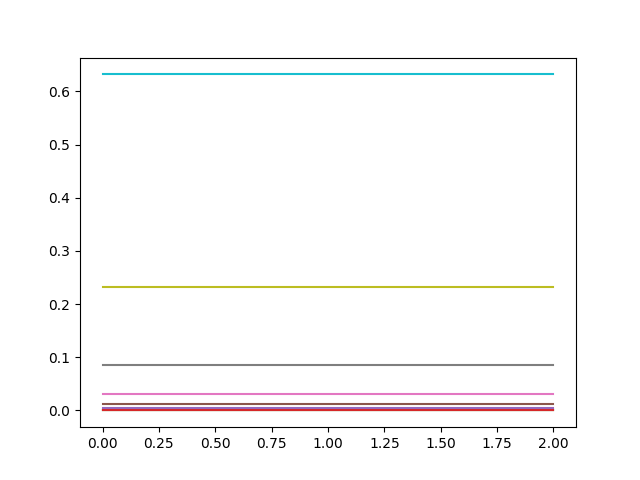

In [7]:
vals = nn.functional.softmax(a)
print(vals.sum())
fig, ax = plt.subplots()
ax.plot(vals)
plt.show()

In [8]:
import yaml 

with open('config_baseline.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


In [9]:
sd = StableDiffusion()



sd = sd.to("cuda")

prompt = ["a photo of an astronaut riding a horse on mars", "a photorealistic cat sitting on a chair"]
images = sd(prompt)
    
images.shape


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([2, 77, 1024])
torch.Size([50])
torch.Size([2, 4, 64, 64])


p:\DCS\venv\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([2, 3, 512, 512])


(2, 512, 512, 3)

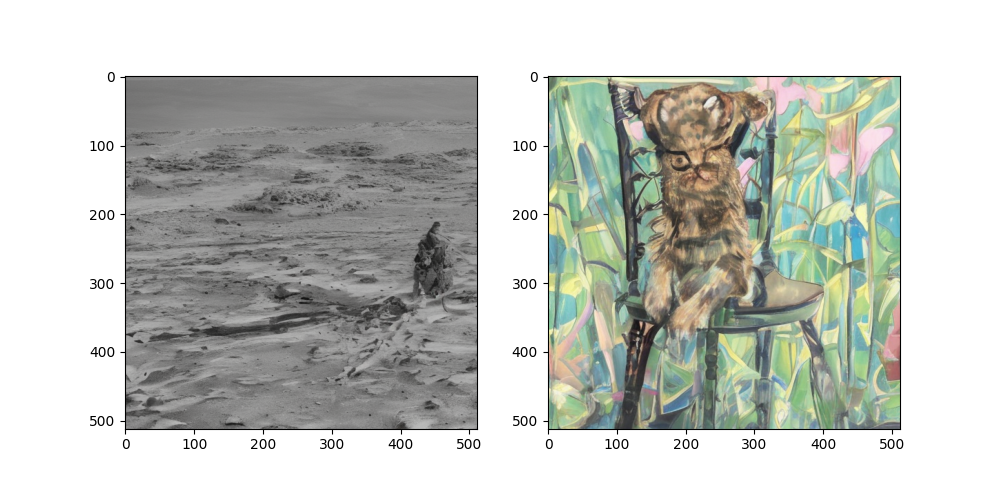

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[0])
ax[1].imshow(images[1])

In [11]:
image_tensor = torch.tensor(images).to("cuda").permute(0, 3, 1, 2).to(torch.bfloat16)
emb_img = sd.encode_image(image_tensor)

torch.Size([2, 4, 64, 64])


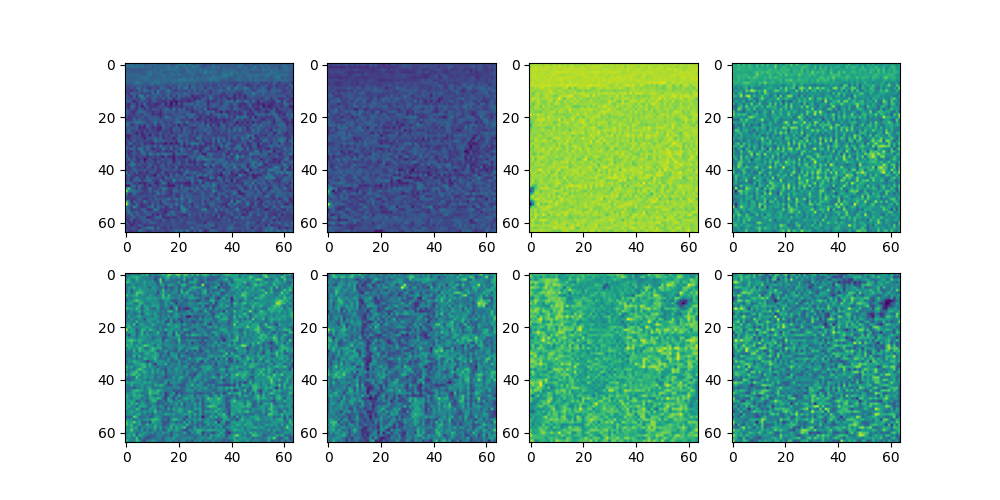

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
print(emb_img.shape)
for i in range(4):
    ax[0, i].imshow(emb_img[0][i].cpu().detach().float().numpy())
    ax[1, i].imshow(emb_img[1][i].cpu().detach().float().numpy())


In [13]:
emb_img.shape

torch.Size([2, 4, 64, 64])

In [14]:
decoded_images = sd.decode_latents(emb_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


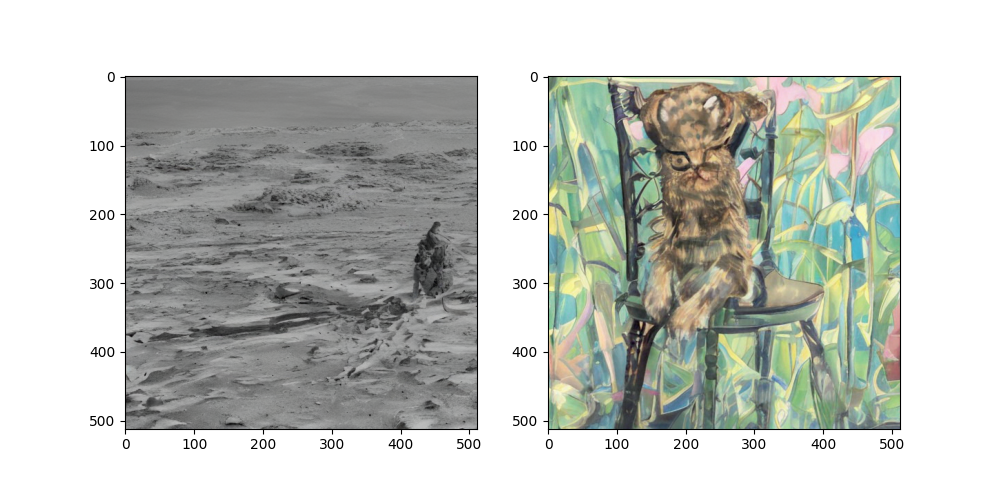

In [15]:
d_imge = decoded_images.permute(0, 2, 3, 1).cpu().detach().float().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(d_imge[0])
ax[1].imshow(d_imge[1])

In [16]:
sd.text_encoder.device

device(type='cuda', index=0)

In [17]:
type(sd.pipe)

diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline

In [18]:
emb  = sd.encode_text(prompt)

In [19]:
emb[0][0]

tensor([-0.3125, -0.4492, -0.0063,  ...,  0.2539, -0.0325, -0.2949],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [20]:
sd.text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-22): 23 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,

In [21]:
from transformers import AutoTokenizer, CLIPModel, CLIPProcessor, CLIPTextModel, CLIPVisionModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [29]:
# from Image to tensor
image_tenor = processor(images=images[0], return_tensors="pt")['pixel_values']
text_tensor = tokenizer(prompt, return_tensors="pt", padding=True)['input_ids']

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [30]:
image_tenor.shape

torch.Size([1, 3, 224, 224])

In [31]:
text_tensor.shape

torch.Size([2, 12])

In [32]:
image_embeddings = model.get_image_features(image_tenor)
text_embeddings = model.get_text_features(text_tensor)

In [34]:
outputs = text_model(**tokenizer(prompt, return_tensors="pt", padding=True))

In [35]:
outputs.last_hidden_state.shape

torch.Size([2, 12, 512])

In [36]:
image_embeddings.shape

torch.Size([1, 512])

In [37]:
text_embeddings.shape

torch.Size([2, 512])

In [ ]:
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

simularity = (100.0 * image_embeddings @ text_embeddings.T).softmax(dim=-1).detach().cpu().numpy()
simularity

array([[1.000000e+00, 4.786988e-10]], dtype=float32)